Epoch 1/30, Training Loss: 1.8997
Epoch 2/30, Training Loss: 0.7680
Epoch 3/30, Training Loss: 0.5793
Epoch 4/30, Training Loss: 0.5816
Epoch 5/30, Training Loss: 0.4594
Epoch 6/30, Training Loss: 0.4354
Epoch 7/30, Training Loss: 0.4128
Epoch 8/30, Training Loss: 0.2938
Epoch 9/30, Training Loss: 0.2910
Epoch 10/30, Training Loss: 0.2888
Epoch 11/30, Training Loss: 0.2916
Epoch 12/30, Training Loss: 0.2916
Epoch 13/30, Training Loss: 0.2916
Epoch 14/30, Training Loss: 0.2916
Epoch 15/30, Training Loss: 0.2888
Epoch 16/30, Training Loss: 0.2888
Epoch 17/30, Training Loss: 0.2916
Epoch 18/30, Training Loss: 0.2910
Epoch 19/30, Training Loss: 0.2888
Epoch 20/30, Training Loss: 0.2910
Epoch 21/30, Training Loss: 0.2938
Epoch 22/30, Training Loss: 0.2888
Epoch 23/30, Training Loss: 0.2910
Epoch 24/30, Training Loss: 0.2916
Epoch 25/30, Training Loss: 0.2910
Epoch 26/30, Training Loss: 0.2943
Epoch 27/30, Training Loss: 0.2910
Epoch 28/30, Training Loss: 0.2888
Epoch 29/30, Training Loss: 0

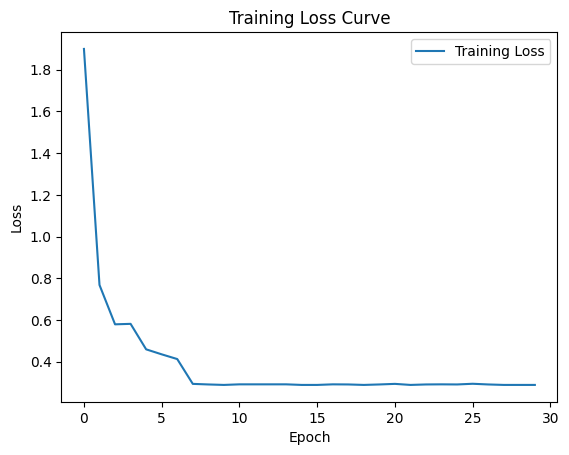

ValueError: Found input variables with inconsistent numbers of samples: [15, 1]

In [11]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

class RBM(nn.Module):
    def __init__(self, visible_units, hidden_units):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(visible_units, hidden_units) * 0.1)
        self.visible_bias = nn.Parameter(torch.zeros(visible_units))
        self.hidden_bias = nn.Parameter(torch.zeros(hidden_units))

    def forward(self, v):
        p_h_given_v = torch.sigmoid(torch.matmul(v, self.W) + self.hidden_bias)
        # Clamp probabilities to ensure they are within [0, 1]
        p_h_given_v = torch.clamp(p_h_given_v, min=0.0001, max=0.9999)  # Adjust min and max as needed
        sample_h_given_v = torch.bernoulli(p_h_given_v)
        return p_h_given_v, sample_h_given_v

    def backward(self, h):
        p_v_given_h = torch.sigmoid(torch.matmul(h, self.W.t()) + self.visible_bias)
        sample_v_given_h = torch.bernoulli(p_v_given_h)
        return p_v_given_h, sample_v_given_h

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=30):
    # Image dimensions
    height, width = 299, 299  # GoogLeNet (InceptionV3) expects input size (299, 299)

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize RBM
    rbm = RBM(visible_units=height * width * 3, hidden_units=64)

    # Loss function
    criterion = nn.BCELoss()

    # Optimizer
    optimizer = optim.Adam(rbm.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        running_loss = 0.0
        for inputs, _ in train_loader:
            inputs = inputs.view(inputs.size(0), -1)
            optimizer.zero_grad()
            v0 = inputs
            ph0, _ = rbm.forward(v0)
            for k in range(10):
                _, hk = rbm.forward(v0)
                _, vk = rbm.backward(hk)
                v0 = vk
            phk, _ = rbm.forward(vk)
            loss = criterion(ph0, phk)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)

        # Print training loss
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}')

    # Plot the learning curve
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    # Confusion Matrix and Classification Report
    y_true = []
    y_pred = []
    rbm.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.view(inputs.size(0), -1)
            _, sample_h_given_v = rbm.forward(inputs)
            p_v_given_h, _ = rbm.backward(sample_h_given_v)
            reconstruction_loss = criterion(inputs, p_v_given_h)
            y_true.extend(labels.numpy())
            y_pred.append(int(reconstruction_loss > 0.5))  # Use threshold for binary classification

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Print Classification Report
    print(classification_report(y_true, y_pred))

# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram"
train_and_evaluate(data_path)


Epoch 1/30, Training Loss: 2.3032
Epoch 2/30, Training Loss: 1.0835
Epoch 3/30, Training Loss: 0.8670
Epoch 4/30, Training Loss: 0.6162
Epoch 5/30, Training Loss: 0.5832
Epoch 6/30, Training Loss: 0.5810
Epoch 7/30, Training Loss: 0.4534
Epoch 8/30, Training Loss: 0.4327
Epoch 9/30, Training Loss: 0.4404
Epoch 10/30, Training Loss: 0.4349
Epoch 11/30, Training Loss: 0.4404
Epoch 12/30, Training Loss: 0.4327
Epoch 13/30, Training Loss: 0.4327
Epoch 14/30, Training Loss: 0.4321
Epoch 15/30, Training Loss: 0.4375
Epoch 16/30, Training Loss: 0.1422
Epoch 17/30, Training Loss: 0.0088
Epoch 18/30, Training Loss: 0.0010
Epoch 19/30, Training Loss: 0.0010
Epoch 20/30, Training Loss: 0.0066
Epoch 21/30, Training Loss: 0.0010
Epoch 22/30, Training Loss: 0.0038
Epoch 23/30, Training Loss: 0.0033
Epoch 24/30, Training Loss: 0.0038
Epoch 25/30, Training Loss: 0.0038
Epoch 26/30, Training Loss: 0.0033
Epoch 27/30, Training Loss: 0.0010
Epoch 28/30, Training Loss: 0.0033
Epoch 29/30, Training Loss: 0

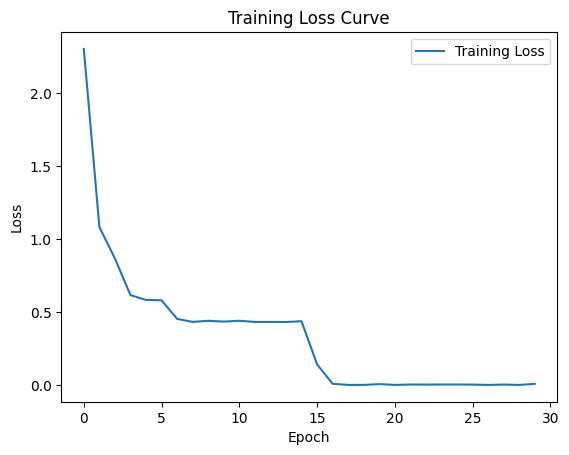

TypeError: iteration over a 0-d array

In [12]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

class RBM(nn.Module):
    def __init__(self, visible_units, hidden_units):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(visible_units, hidden_units) * 0.1)
        self.visible_bias = nn.Parameter(torch.zeros(visible_units))
        self.hidden_bias = nn.Parameter(torch.zeros(hidden_units))

    def forward(self, v):
        p_h_given_v = torch.sigmoid(torch.matmul(v, self.W) + self.hidden_bias)
        # Clamp probabilities to ensure they are within [0, 1]
        p_h_given_v = torch.clamp(p_h_given_v, min=0.0001, max=0.9999)  # Adjust min and max as needed
        sample_h_given_v = torch.bernoulli(p_h_given_v)
        return p_h_given_v, sample_h_given_v

    def backward(self, h):
        p_v_given_h = torch.sigmoid(torch.matmul(h, self.W.t()) + self.visible_bias)
        sample_v_given_h = torch.bernoulli(p_v_given_h)
        return p_v_given_h, sample_v_given_h

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=30):
    # Image dimensions
    height, width = 299, 299  # GoogLeNet (InceptionV3) expects input size (299, 299)

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize RBM
    rbm = RBM(visible_units=height * width * 3, hidden_units=64)

    # Loss function
    criterion = nn.BCELoss()

    # Optimizer
    optimizer = optim.Adam(rbm.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        running_loss = 0.0
        for inputs, _ in train_loader:
            inputs = inputs.view(inputs.size(0), -1)
            optimizer.zero_grad()
            v0 = inputs
            ph0, _ = rbm.forward(v0)
            for k in range(10):
                _, hk = rbm.forward(v0)
                _, vk = rbm.backward(hk)
                v0 = vk
            phk, _ = rbm.forward(vk)
            loss = criterion(ph0, phk)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)

        # Print training loss
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}')

    # Plot the learning curve
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    # Confusion Matrix and Classification Report
    y_true = []
    y_pred = []
    rbm.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.view(inputs.size(0), -1)
            _, sample_h_given_v = rbm.forward(inputs)
            p_v_given_h, _ = rbm.backward(sample_h_given_v)
            reconstruction_loss = criterion(inputs, p_v_given_h)
            y_true.extend(labels.numpy())
            y_pred.extend((reconstruction_loss > 0.5).int().numpy())  # Use threshold for binary classification

    # Ensure y_pred has the same number of elements as y_true
    y_pred = np.array(y_pred)[:len(y_true)]

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Print Classification Report
    print(classification_report(y_true, y_pred))

# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram"
train_and_evaluate(data_path)



Epoch 1/30, Training Loss: 2.3467
Epoch 2/30, Training Loss: 0.8126
Epoch 3/30, Training Loss: 0.5738
Epoch 4/30, Training Loss: 0.5771
Epoch 5/30, Training Loss: 0.4511
Epoch 6/30, Training Loss: 0.4349
Epoch 7/30, Training Loss: 0.4354
Epoch 8/30, Training Loss: 0.3746
Epoch 9/30, Training Loss: 0.2983
Epoch 10/30, Training Loss: 0.2891
Epoch 11/30, Training Loss: 0.2888
Epoch 12/30, Training Loss: 0.2938
Epoch 13/30, Training Loss: 0.2910
Epoch 14/30, Training Loss: 0.2916
Epoch 15/30, Training Loss: 0.2943
Epoch 16/30, Training Loss: 0.2888
Epoch 17/30, Training Loss: 0.2888
Epoch 18/30, Training Loss: 0.2910
Epoch 19/30, Training Loss: 0.2888
Epoch 20/30, Training Loss: 0.2888
Epoch 21/30, Training Loss: 0.2916
Epoch 22/30, Training Loss: 0.2910
Epoch 23/30, Training Loss: 0.2888
Epoch 24/30, Training Loss: 0.2888
Epoch 25/30, Training Loss: 0.2888
Epoch 26/30, Training Loss: 0.2888
Epoch 27/30, Training Loss: 0.2888
Epoch 28/30, Training Loss: 0.2888
Epoch 29/30, Training Loss: 0

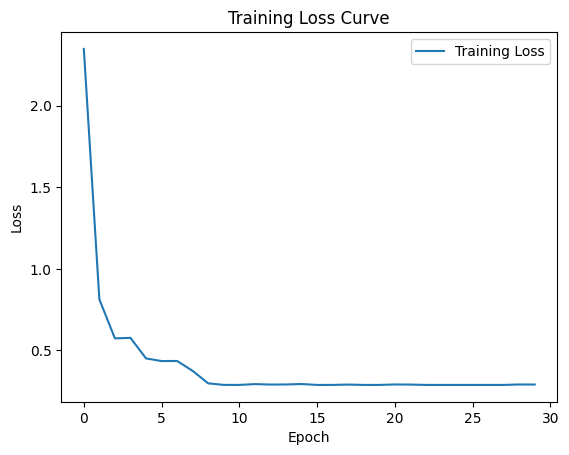

TypeError: iteration over a 0-d array

In [13]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

class RBM(nn.Module):
    def __init__(self, visible_units, hidden_units):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(visible_units, hidden_units) * 0.1)
        self.visible_bias = nn.Parameter(torch.zeros(visible_units))
        self.hidden_bias = nn.Parameter(torch.zeros(hidden_units))

    def forward(self, v):
        p_h_given_v = torch.sigmoid(torch.matmul(v, self.W) + self.hidden_bias)
        # Clamp probabilities to ensure they are within [0, 1]
        p_h_given_v = torch.clamp(p_h_given_v, min=0.0001, max=0.9999)  # Adjust min and max as needed
        sample_h_given_v = torch.bernoulli(p_h_given_v)
        return p_h_given_v, sample_h_given_v

    def backward(self, h):
        p_v_given_h = torch.sigmoid(torch.matmul(h, self.W.t()) + self.visible_bias)
        sample_v_given_h = torch.bernoulli(p_v_given_h)
        return p_v_given_h, sample_v_given_h

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=30):
    # Image dimensions
    height, width = 299, 299  # GoogLeNet (InceptionV3) expects input size (299, 299)

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize RBM
    rbm = RBM(visible_units=height * width * 3, hidden_units=64)

    # Loss function
    criterion = nn.BCELoss()

    # Optimizer
    optimizer = optim.Adam(rbm.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        running_loss = 0.0
        for inputs, _ in train_loader:
            inputs = inputs.view(inputs.size(0), -1)
            optimizer.zero_grad()
            v0 = inputs
            ph0, _ = rbm.forward(v0)
            for k in range(10):
                _, hk = rbm.forward(v0)
                _, vk = rbm.backward(hk)
                v0 = vk
            phk, _ = rbm.forward(vk)
            loss = criterion(ph0, phk)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)

        # Print training loss
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}')

    # Plot the learning curve
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    # Confusion Matrix and Classification Report
    y_true = []
    y_pred = []
    rbm.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.view(inputs.size(0), -1)
            _, sample_h_given_v = rbm.forward(inputs)
            p_v_given_h, _ = rbm.backward(sample_h_given_v)
            reconstruction_loss = criterion(inputs, p_v_given_h)
            y_true.extend(labels.numpy())
            y_pred.extend((reconstruction_loss > 0.5).int().numpy())  # Use threshold for binary classification

    # Ensure y_pred has the same number of elements as y_true
    y_pred = np.array(y_pred)[:len(y_true)]

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Print Classification Report
    print(classification_report(y_true, y_pred))

# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram"
train_and_evaluate(data_path)


Epoch 1/30, Training Loss: 2.8294, Validation Loss: 1.3821
Epoch 2/30, Training Loss: 1.2382, Validation Loss: 1.1423
Epoch 3/30, Training Loss: 1.1476, Validation Loss: 1.0368
Epoch 4/30, Training Loss: 1.0085, Validation Loss: 0.7764
Epoch 5/30, Training Loss: 0.7491, Validation Loss: 0.6053
Epoch 6/30, Training Loss: 0.6109, Validation Loss: 0.5765
Epoch 7/30, Training Loss: 0.5258, Validation Loss: 0.4423
Epoch 8/30, Training Loss: 0.4344, Validation Loss: 0.3272
Epoch 9/30, Training Loss: 0.3207, Validation Loss: 0.2888
Epoch 10/30, Training Loss: 0.2888, Validation Loss: 0.2888
Epoch 11/30, Training Loss: 0.2500, Validation Loss: 0.1449
Epoch 12/30, Training Loss: 0.1449, Validation Loss: 0.1449
Epoch 13/30, Training Loss: 0.1472, Validation Loss: 0.1449
Epoch 14/30, Training Loss: 0.1499, Validation Loss: 0.1449
Epoch 15/30, Training Loss: 0.1504, Validation Loss: 0.1449
Epoch 16/30, Training Loss: 0.1449, Validation Loss: 0.1449
Epoch 17/30, Training Loss: 0.1494, Validation Lo

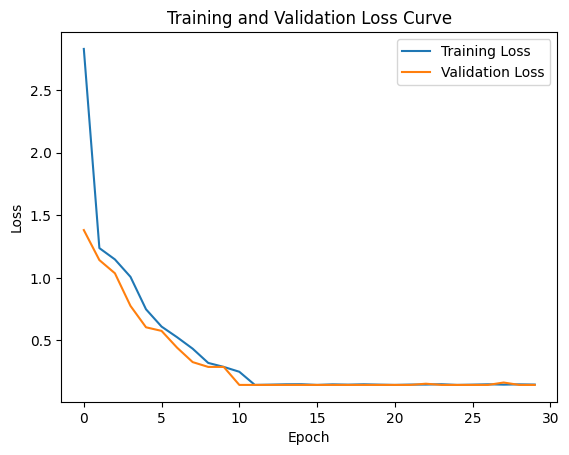

In [14]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

class RBM(nn.Module):
    def __init__(self, visible_units, hidden_units):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(visible_units, hidden_units) * 0.1)
        self.visible_bias = nn.Parameter(torch.zeros(visible_units))
        self.hidden_bias = nn.Parameter(torch.zeros(hidden_units))

    def forward(self, v):
        p_h_given_v = torch.sigmoid(torch.matmul(v, self.W) + self.hidden_bias)
        # Clamp probabilities to ensure they are within [0, 1]
        p_h_given_v = torch.clamp(p_h_given_v, min=0.0001, max=0.9999)  # Adjust min and max as needed
        sample_h_given_v = torch.bernoulli(p_h_given_v)
        return p_h_given_v, sample_h_given_v

    def backward(self, h):
        p_v_given_h = torch.sigmoid(torch.matmul(h, self.W.t()) + self.visible_bias)
        sample_v_given_h = torch.bernoulli(p_v_given_h)
        return p_v_given_h, sample_v_given_h

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=30):
    # Image dimensions
    height, width = 299, 299  # GoogLeNet (InceptionV3) expects input size (299, 299)

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize RBM
    rbm = RBM(visible_units=height * width * 3, hidden_units=64)

    # Loss function
    criterion = nn.BCELoss()

    # Optimizer
    optimizer = optim.Adam(rbm.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        rbm.train()
        running_train_loss = 0.0
        for inputs, _ in train_loader:
            inputs = inputs.view(inputs.size(0), -1)
            optimizer.zero_grad()
            v0 = inputs
            ph0, _ = rbm.forward(v0)
            for k in range(10):
                _, hk = rbm.forward(v0)
                _, vk = rbm.backward(hk)
                v0 = vk
            phk, _ = rbm.forward(vk)
            train_loss = criterion(ph0, phk)
            train_loss.backward()
            optimizer.step()
            running_train_loss += train_loss.item()

        average_train_loss = running_train_loss / len(train_loader)
        train_losses.append(average_train_loss)

        # Validation
        rbm.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, _ in val_loader:
                inputs = inputs.view(inputs.size(0), -1)
                v0 = inputs
                ph0, _ = rbm.forward(v0)
                for k in range(10):
                    _, hk = rbm.forward(v0)
                    _, vk = rbm.backward(hk)
                    v0 = vk
                phk, _ = rbm.forward(vk)
                val_loss = criterion(ph0, phk)
                running_val_loss += val_loss.item()

        average_val_loss = running_val_loss / len(val_loader)
        val_losses.append(average_val_loss)

        # Print training and validation loss
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Validation Loss: {average_val_loss:.4f}')

    # Plot the learning curve
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curve')
    plt.legend()
    plt.show()

# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram"
train_and_evaluate(data_path)


code below : decrease batch size from 32 to 16 and increase epoch to 100

Epoch 1/100, Training Loss: 1.8120, Validation Loss: 1.0762
Epoch 2/100, Training Loss: 0.9223, Validation Loss: 0.5765
Epoch 3/100, Training Loss: 0.5810, Validation Loss: 0.5478
Epoch 4/100, Training Loss: 0.4800, Validation Loss: 0.2878
Epoch 5/100, Training Loss: 0.2551, Validation Loss: 0.1449
Epoch 6/100, Training Loss: 0.1516, Validation Loss: 0.1449
Epoch 7/100, Training Loss: 0.1427, Validation Loss: 0.1545
Epoch 8/100, Training Loss: 0.0464, Validation Loss: 0.0010
Epoch 9/100, Training Loss: 0.0046, Validation Loss: 0.0106
Epoch 10/100, Training Loss: 0.0010, Validation Loss: 0.0202
Epoch 11/100, Training Loss: 0.0033, Validation Loss: 0.0106
Epoch 12/100, Training Loss: 0.0033, Validation Loss: 0.0010
Epoch 13/100, Training Loss: 0.0033, Validation Loss: 0.0010
Epoch 14/100, Training Loss: 0.0010, Validation Loss: 0.0010
Epoch 15/100, Training Loss: 0.0033, Validation Loss: 0.0010
Epoch 16/100, Training Loss: 0.0033, Validation Loss: 0.0106
Epoch 17/100, Training Loss: 0.00

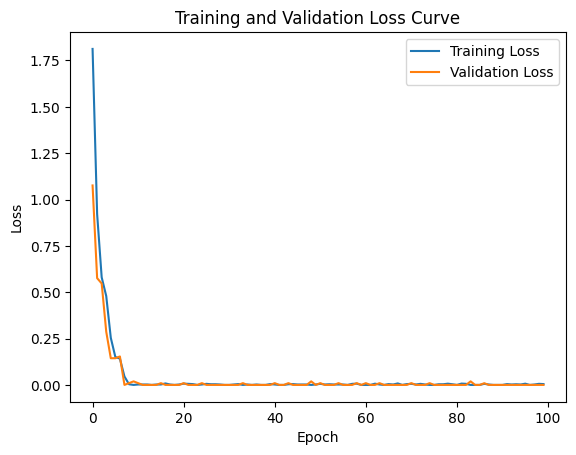

In [15]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

class RBM(nn.Module):
    def __init__(self, visible_units, hidden_units):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(visible_units, hidden_units) * 0.1)
        self.visible_bias = nn.Parameter(torch.zeros(visible_units))
        self.hidden_bias = nn.Parameter(torch.zeros(hidden_units))

    def forward(self, v):
        p_h_given_v = torch.sigmoid(torch.matmul(v, self.W) + self.hidden_bias)
        # Clamp probabilities to ensure they are within [0, 1]
        p_h_given_v = torch.clamp(p_h_given_v, min=0.0001, max=0.9999)  # Adjust min and max as needed
        sample_h_given_v = torch.bernoulli(p_h_given_v)
        return p_h_given_v, sample_h_given_v

    def backward(self, h):
        p_v_given_h = torch.sigmoid(torch.matmul(h, self.W.t()) + self.visible_bias)
        sample_v_given_h = torch.bernoulli(p_v_given_h)
        return p_v_given_h, sample_v_given_h

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=100):
    # Image dimensions
    height, width = 299, 299  # GoogLeNet (InceptionV3) expects input size (299, 299)

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    # Initialize RBM
    rbm = RBM(visible_units=height * width * 3, hidden_units=64)

    # Loss function
    criterion = nn.BCELoss()

    # Optimizer
    optimizer = optim.Adam(rbm.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        rbm.train()
        running_train_loss = 0.0
        for inputs, _ in train_loader:
            inputs = inputs.view(inputs.size(0), -1)
            optimizer.zero_grad()
            v0 = inputs
            ph0, _ = rbm.forward(v0)
            for k in range(10):
                _, hk = rbm.forward(v0)
                _, vk = rbm.backward(hk)
                v0 = vk
            phk, _ = rbm.forward(vk)
            train_loss = criterion(ph0, phk)
            train_loss.backward()
            optimizer.step()
            running_train_loss += train_loss.item()

        average_train_loss = running_train_loss / len(train_loader)
        train_losses.append(average_train_loss)

        # Validation
        rbm.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, _ in val_loader:
                inputs = inputs.view(inputs.size(0), -1)
                v0 = inputs
                ph0, _ = rbm.forward(v0)
                for k in range(10):
                    _, hk = rbm.forward(v0)
                    _, vk = rbm.backward(hk)
                    v0 = vk
                phk, _ = rbm.forward(vk)
                val_loss = criterion(ph0, phk)
                running_val_loss += val_loss.item()

        average_val_loss = running_val_loss / len(val_loader)
        val_losses.append(average_val_loss)

        # Print training and validation loss
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Validation Loss: {average_val_loss:.4f}')

    # Plot the learning curve
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curve')
    plt.legend()
    plt.show()

# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram"
train_and_evaluate(data_path)


Epoch 1/50, Training Loss: 1.9224, Validation Loss: 0.8739, Training Accuracy: 130108.1724, Validation Accuracy: 130501.9333
Epoch 2/50, Training Loss: 0.7647, Validation Loss: 0.7111, Training Accuracy: 130108.1724, Validation Accuracy: 130501.9333
Epoch 3/50, Training Loss: 0.6228, Validation Loss: 0.5765, Training Accuracy: 130108.1724, Validation Accuracy: 130501.9333
Epoch 4/50, Training Loss: 0.5720, Validation Loss: 0.5765, Training Accuracy: 130108.1724, Validation Accuracy: 130501.9333
Epoch 5/50, Training Loss: 0.5765, Validation Loss: 0.5765, Training Accuracy: 130108.1724, Validation Accuracy: 130501.9333
Epoch 6/50, Training Loss: 0.5788, Validation Loss: 0.5765, Training Accuracy: 130108.1724, Validation Accuracy: 130501.9333
Epoch 7/50, Training Loss: 0.5833, Validation Loss: 0.5765, Training Accuracy: 130108.1724, Validation Accuracy: 130501.9333
Epoch 8/50, Training Loss: 0.5788, Validation Loss: 0.5765, Training Accuracy: 130108.1724, Validation Accuracy: 130501.9333


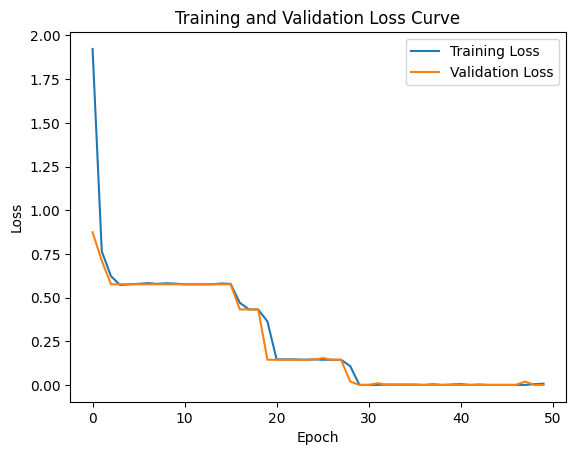

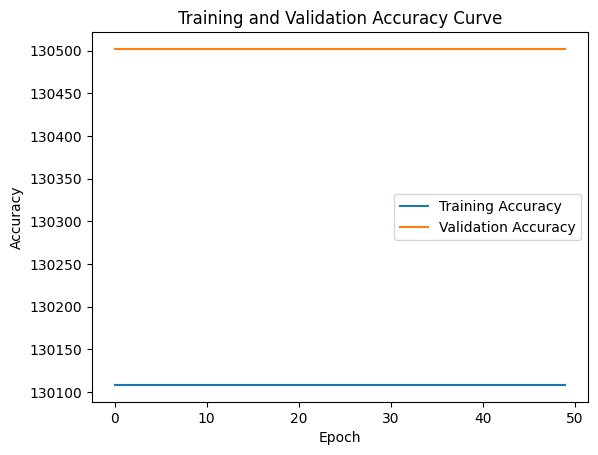

ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

class RBM(nn.Module):
    def __init__(self, visible_units, hidden_units):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(visible_units, hidden_units) * 0.1)
        self.visible_bias = nn.Parameter(torch.zeros(visible_units))
        self.hidden_bias = nn.Parameter(torch.zeros(hidden_units))

    def forward(self, v):
        p_h_given_v = torch.sigmoid(torch.matmul(v, self.W) + self.hidden_bias)
        # Clamp probabilities to ensure they are within [0, 1]
        p_h_given_v = torch.clamp(p_h_given_v, min=0.0001, max=0.9999)  # Adjust min and max as needed
        sample_h_given_v = torch.bernoulli(p_h_given_v)
        return p_h_given_v, sample_h_given_v

    def backward(self, h):
        p_v_given_h = torch.sigmoid(torch.matmul(h, self.W.t()) + self.visible_bias)
        sample_v_given_h = torch.bernoulli(p_v_given_h)
        return p_v_given_h, sample_v_given_h

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=50):
    # Image dimensions
    height, width = 299, 299  # GoogLeNet (InceptionV3) expects input size (299, 299)

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    # Initialize RBM
    rbm = RBM(visible_units=height * width * 3, hidden_units=64)

    # Loss function
    criterion = nn.BCELoss()

    # Optimizer
    optimizer = optim.Adam(rbm.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        rbm.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, _ in train_loader:
            inputs = inputs.view(inputs.size(0), -1)
            optimizer.zero_grad()
            v0 = inputs
            ph0, _ = rbm.forward(v0)
            for k in range(10):
                _, hk = rbm.forward(v0)
                _, vk = rbm.backward(hk)
                v0 = vk
            phk, _ = rbm.forward(vk)
            train_loss = criterion(ph0, phk)
            train_loss.backward()
            optimizer.step()
            running_train_loss += train_loss.item()
            _, predicted = phk.round().long().squeeze(), inputs.round().long().squeeze()
            total_train += inputs.size(0)
            correct_train += (predicted == inputs).sum().item()
        
        average_train_loss = running_train_loss / len(train_loader)
        train_losses.append(average_train_loss)
        train_accuracy.append(correct_train / total_train)

        # Validation
        rbm.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, _ in val_loader:
                inputs = inputs.view(inputs.size(0), -1)
                v0 = inputs
                ph0, _ = rbm.forward(v0)
                for k in range(10):
                    _, hk = rbm.forward(v0)
                    _, vk = rbm.backward(hk)
                    v0 = vk
                phk, _ = rbm.forward(vk)
                val_loss = criterion(ph0, phk)
                running_val_loss += val_loss.item()
                _, predicted = phk.round().long().squeeze(), inputs.round().long().squeeze()
                total_val += inputs.size(0)
                correct_val += (predicted == inputs).sum().item()
        
        average_val_loss = running_val_loss / len(val_loader)
        val_losses.append(average_val_loss)
        val_accuracy.append(correct_val / total_val)

        # Print training and validation loss
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Validation Loss: {average_val_loss:.4f}, '
              f'Training Accuracy: {train_accuracy[-1]:.4f}, '
              f'Validation Accuracy: {val_accuracy[-1]:.4f}')

    # Plot the learning curve
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curve')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Curve')
    plt.legend()
    plt.show()

    # Compute confusion matrix
    all_labels = []
    all_predictions = []
    rbm.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.view(inputs.size(0), -1)
            v0 = inputs
            ph0, _ = rbm.forward(v0)
            for k in range(10):
                _, hk = rbm.forward(v0)
                _, vk = rbm.backward(hk)
                v0 = vk
            phk, _ = rbm.forward(vk)
            _, predicted = phk.round().long().squeeze(), inputs.round().long().squeeze()
            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.show()

# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram"
train_and_evaluate(data_path)


earlier code was not normalised to 0-1

In [9]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Define RBM class
class RBM(nn.Module):
    def __init__(self, visible_units, hidden_units):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(visible_units, hidden_units)*0.1)
        self.v_bias = nn.Parameter(torch.zeros(visible_units))
        self.h_bias = nn.Parameter(torch.zeros(hidden_units))

    def sample_hidden(self, x):
        p_h_given_v = torch.sigmoid(torch.matmul(x, self.W) + self.h_bias)
        return p_h_given_v, torch.bernoulli(p_h_given_v)

    def sample_visible(self, y):
        p_v_given_h = torch.sigmoid(torch.matmul(y, self.W.t()) + self.v_bias)
        return p_v_given_h, torch.bernoulli(p_v_given_h)

    def forward(self, x):
        _, h = self.sample_hidden(x)
        _, v = self.sample_visible(h)
        return v

# Define the training function
def train_and_evaluate(data_path):
    # Load data
    # Assume that the dataset is loaded and preprocessed appropriately
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    # Initialize RBM
    rbm = RBM(visible_units, hidden_units)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(rbm.parameters(), lr=learning_rate)

    # Training loop
    train_losses = []
    valid_losses = []
    for epoch in range(num_epochs):
        rbm.train()
        running_train_loss = 0.0
        for batch in train_loader:
            inputs, labels = batch
            inputs = inputs.view(inputs.size(0), -1)

            optimizer.zero_grad()

            p_h_given_v, h = rbm.sample_hidden(inputs)
            p_v_given_h, v = rbm.sample_visible(h)

            reconstruction_loss = criterion(inputs, p_v_given_h)
            reconstruction_loss.backward()
            optimizer.step()

            running_train_loss += reconstruction_loss.item() * inputs.size(0)

        average_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(average_train_loss)

        # Validation loop
        rbm.eval()
        running_valid_loss = 0.0
        with torch.no_grad():
            for batch in valid_loader:
                inputs, labels = batch
                inputs = inputs.view(inputs.size(0), -1)

                p_h_given_v, h = rbm.sample_hidden(inputs)
                p_v_given_h, v = rbm.sample_visible(h)

                valid_loss = criterion(inputs, p_v_given_h)
                running_valid_loss += valid_loss.item() * inputs.size(0)

        average_valid_loss = running_valid_loss / len(valid_loader.dataset)
        valid_losses.append(average_valid_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {average_train_loss:.4f}, Validation Loss: {average_valid_loss:.4f}")

    # Plot training and validation losses
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

# Parameters
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram"
batch_size = 64
num_epochs = 100
learning_rate = 0.001
visible_units = 784  # Assuming input size is 28x28
hidden_units = 64

# Define train_dataset and valid_dataset here

# Example usage
train_and_evaluate(data_path)


NameError: name 'train_dataset' is not defined